<a href="https://colab.research.google.com/github/Byte-Maste/AI-Powered-Bug-Detection-and-fixing/blob/main/dataset_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mutmut
!pip install astor
!pip install libcst

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.8/681.8 kB 17.5 MB/s eta 0:00:00
  Created wheel for junit-xml: filename=junit_xml-1.8-py3-none-any.whl size=6762 sha256=e69d1fa9e625c78d03072c3f0a70e45dd2a5f01ee5bc7cf15ecce5f91d918843
  Stored in directory: /root/.cache/pip/wheels/83/2a/30/0e0038a62b9687d7702ea61144547011ecc1c12dd9dced6142
Successfully built junit-xml
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.8 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
import csv
import json
from collections.abc import Iterator
import ast
import astor
import random
import libcst as cst
import libcst.matchers as m
from decimal import Decimal
import math

Reading Dataset

In [32]:
import pandas as pd
import requests
from io import StringIO

# Original Google Drive viewing URL
view_url = "https://drive.google.com/file/d/1Arr83X51S0oAveSXjPyUzTBv-oT1cm-v/view?usp=sharing"

# Extract the file ID from the URL
file_id = view_url.split('/d/')[1].split('/view')[0]

# Create the direct download link
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"

# Read the CSV file using the direct download link
df = pd.read_csv(download_url)

# Print the number of rows in the dataframe
print(f"Number of Dataframe rows: {df.shape[0]}")

# Display the first few rows of the dataframe
df.head()

Number of Dataframe rows: 25793


,unstructured_code
0,# Original Code (Snippet 1):\nn = int(input())...
1,# Original Code (Snippet 2):\nn = int(input())...
2,# Original Code (Snippet 3):\nn = int(input())...
3,# Original Code (Snippet 4):\nn = int(input())...
4,# Original Code (Snippet 5):\nn = int(input())...


In [33]:
# Reducing the number of rows
desired_rows = 6000
selected_list = []
final_df = pd.DataFrame(columns=['unstructured_code'])
while desired_rows != len(selected_list):
  rand_row = random.randrange(0, df.shape[0])
  if rand_row not in selected_list:
    selected_list.append(rand_row)
    final_df = pd.concat([final_df, pd.DataFrame(df['unstructured_code'][rand_row:rand_row+1])])
df = final_df.reset_index(drop=True)
print(df.shape)
df.head()

(6000, 1)


,unstructured_code
0,"# Original Code (Snippet 12237):\narray_g, arr..."
1,# Original Code (Snippet 23625):\nn = int(inpu...
2,# Original Code (Snippet 12307):\nn = int(inpu...
3,# Original Code (Snippet 149):\nx=int(input())...
4,# Original Code (Snippet 12926):\nimport math\...


In [34]:
print(df.shape)
df.head()

(6000, 1)


,unstructured_code
0,"# Original Code (Snippet 12237):\narray_g, arr..."
1,# Original Code (Snippet 23625):\nn = int(inpu...
2,# Original Code (Snippet 12307):\nn = int(inpu...
3,# Original Code (Snippet 149):\nx=int(input())...
4,# Original Code (Snippet 12926):\nimport math\...


Mutating Code

In this section, we use mutation techniques with the CST library. We change operations in the code and randomly replace them with other operations supported by CST.

Why are we using CST?

We prefer CST over AST because CST preserves the formatting and structure of the code. With CST, we can maintain whitespace, comments, and other stylistic elements that would be lost with AST. Our goal is to produce mutated code along with information about which specific line was changed.

In [ ]:
# This cell is used for randomly selecting mutation techniques and applying them to codes

# Initialize the global variable for operations
flag = False
op_list = []

class OperationChanger(cst.CSTTransformer):
    select_operations = [
        cst.Add, cst.Subtract, cst.Multiply, cst.Divide,
        cst.Modulo, cst.Power, cst.FloorDivide,
        cst.LeftShift, cst.RightShift,
        cst.BitOr, cst.BitXor, cst.BitAnd,
        cst.MatrixMultiply
    ]

    operations = [
        cst.Add(), cst.Subtract(), cst.Multiply(), cst.Divide(),
        cst.Modulo(), cst.Power(), cst.FloorDivide(),
        cst.LeftShift(), cst.RightShift(),
        cst.BitOr(), cst.BitXor(), cst.BitAnd(),
        cst.MatrixMultiply()
    ]

    def __init__(self):
        super().__init__()
        self.changed = False  # Flag to track if a change has been made
        global flag
        flag = False  # Ensure global flag is initialized properly

    def leave_BinaryOperation(self, original_node, updated_node):
        global flag  # Declare that we're working with the global 'flag'
        if not self.changed:
            available_op_list = list(set(self.select_operations) - set(op_list))
            if len(available_op_list) == 0:
                available_op_list = self.select_operations
                op_list.clear()

            current_op = random.choice(available_op_list)
            op_list.append(current_op)

            new_op_to_change = random.choice(self.operations)
            if isinstance(updated_node.operator, current_op):
                self.changed = True
                flag = True
                return updated_node.with_changes(
                    operator=new_op_to_change.with_changes(
                        whitespace_before=cst.SimpleWhitespace(value=''),
                        whitespace_after=cst.SimpleWhitespace(value='')
                    )
                )
        return updated_node

# Define OperandCollector and SingleOperandModifier
class OperandCollector(cst.CSTVisitor):
    def __init__(self):
        self.operands = []

    def visit_Name(self, node):
        self.operands.append(node)

class SingleOperandModifier(cst.CSTTransformer):
    def __init__(self, operand_to_modify):
        self.operand_to_modify = operand_to_modify

    def leave_Name(self, original_node, updated_node):
        if original_node == self.operand_to_modify:
            new_name = random.choice(['x', 'y', 'z'])
            return updated_node.with_changes(value=new_name)
        return updated_node

# Define the NumberCollector and NumberModifier
class NumberCollector(cst.CSTVisitor):
    def __init__(self):
        self.numbers = []

    def visit_Integer(self, node):
        self.numbers.append(node)

    def visit_Float(self, node):
        self.numbers.append(node)

class NumberModifier(cst.CSTTransformer):
    def __init__(self, target_node):
        super().__init__()
        self.target_node = target_node

    def leave_Integer(self, original_node, updated_node):
        rand_num = random.randrange(1, 200)
        if original_node == self.target_node:
            return updated_node.with_changes(value=str(rand_num))
        return updated_node

    def leave_Float(self, original_node, updated_node):
        rand_num = random.randrange(1, 200)
        rand_float = random.randrange(1, 10)
        if original_node == self.target_node:
            return updated_node.with_changes(value=str(rand_num) + '.' + str(rand_float))
        return updated_node

# Define the ComparisonCollector and SingleComparisonModifier
class ComparisonCollector(cst.CSTVisitor):
    def __init__(self):
        self.comparisons = []

    def visit_Comparison(self, node):
        self.comparisons.append(node)

class SingleComparisonModifier(cst.CSTTransformer):
    def __init__(self, target_node):
        super().__init__()
        self.target_node = target_node

    def leave_Comparison(self, original_node, updated_node):
        if original_node == self.target_node:
            modified_ops = []
            for operator in updated_node.comparisons:
                if isinstance(operator.operator, cst.LessThan):
                    modified_ops.append(
                        operator.with_changes(
                            operator=cst.GreaterThan().with_changes(
                                whitespace_before=cst.SimpleWhitespace(value=''),
                                whitespace_after=cst.SimpleWhitespace(value='')
                            )
                        )
                    )
                elif isinstance(operator.operator, cst.GreaterThan):
                    modified_ops.append(
                        operator.with_changes(
                            operator=cst.Equal().with_changes(
                                whitespace_before=cst.SimpleWhitespace(value=''),
                                whitespace_after=cst.SimpleWhitespace(value='')
                            )
                        )
                    )
                elif isinstance(operator.operator, cst.Equal):
                    modified_ops.append(
                        operator.with_changes(
                            operator=cst.LessThan().with_changes(
                                whitespace_before=cst.SimpleWhitespace(value=''),
                                whitespace_after=cst.SimpleWhitespace(value='')
                            )
                        )
                    )
                elif isinstance(operator.operator, cst.GreaterThanEqual):
                    modified_ops.append(
                        operator.with_changes(
                            operator=cst.LessThanEqual().with_changes(
                                whitespace_before=cst.SimpleWhitespace(value=''),
                                whitespace_after=cst.SimpleWhitespace(value='')
                            )
                        )
                    )
                elif isinstance(operator.operator, cst.LessThanEqual):
                    modified_ops.append(
                        operator.with_changes(
                            operator=cst.GreaterThanEqual().with_changes(
                                whitespace_before=cst.SimpleWhitespace(value=''),
                                whitespace_after=cst.SimpleWhitespace(value='')
                            )
                        )
                    )
                else:
                    modified_ops.append(operator)
            return updated_node.with_changes(comparisons=modified_ops)
        return updated_node

# Function to randomly select a section and apply the corresponding modification
def randomly_modify_code(tree, code):
    sections = [
        'value',
        'statement',
        'operation',
        'decision'
    ]

    randomList = random.choices(
    sections, weights=(1, 1, 3, 3), k=1)

    selected_section = randomList[0]

    if selected_section == 'operation':
        # print("Selected section: Operation")
        global flag  # Ensure we're working with the global flag
        flag = False  # Reset flag for each call
        modified_tree = tree  # Ensure modified_tree is initialized
        retries = 0
        while not flag and retries < 100:  # Add a retry limit
            transformer = OperationChanger()
            modified_tree = tree.visit(transformer)  # Apply the transformation
            retries += 1  # Increment retry count
        return modified_tree, selected_section

    elif selected_section == 'value':
        # print("Selected section: Value")
        collector = NumberCollector()
        tree.visit(collector)
        if collector.numbers:
            target_node = random.choice(collector.numbers)
            transformer = NumberModifier(target_node)
            modified_tree = tree.visit(transformer)
            return modified_tree, selected_section

    elif selected_section == 'decision':
        # print("Selected section: Decision")
        collector = ComparisonCollector()
        tree.visit(collector)
        if collector.comparisons:
            target_node = random.choice(collector.comparisons)
            transformer = SingleComparisonModifier(target_node)
            modified_tree = tree.visit(transformer)
            return modified_tree, selected_section

    elif selected_section == 'statement':
        # print("Selected section: Statement")
        collector = OperandCollector()
        tree.visit(collector)
        if collector.operands:
            operand_to_modify = random.choice(collector.operands)
            modifier = SingleOperandModifier(operand_to_modify)
            modified_tree = tree.visit(modifier)
            return modified_tree, selected_section

    return tree, None

# Function to modify and print the code
def modify_and_print_code(code):
    # Parse the input code into a CST tree
    tree = cst.parse_module(code)

    # Apply random modifications
    modified_tree, selected_section = randomly_modify_code(tree, code)

    # Convert the modified tree back to a code string
    modified_code = modified_tree.code

    # Print the modified code
    # print("Original Code:")
    # print(code)
    # print("\nModified Code:")
    return modified_code, selected_section

In [ ]:
# This function is used for comparing two codes and shown which line changed
def find_difference(original_code, modified_code):
  # Find witch line has changed
  changed_lines = []
  line = 1;
  num_line = -1
  for original, mutated in zip(original_code.split('\n'), modified_code.split('\n')):
      if original != mutated:
        # print(f"Line {line} has changed")
        num_line = line
        changed_lines.append(mutated)
      line += 1

  # Output changed lines
  if changed_lines:
      # print("\n--- Changed Lines ---")
      for changed_line in changed_lines:
          return changed_line, num_line
  else:
      return "No changes detected.", num_line

In [ ]:
# Create an empty DataFrame to store the results
final_dataset = pd.DataFrame(columns=['original_code', 'modified_code', 'changed_line', 'line_number', 'mutation_type'])

# Initialize a counter for iterations
iteration_num = 1

# Loop through each row in the dataset
for row in range(df.shape[0]):
    try:
        # Get the original code from the dataset
        original_code = df.iloc[row]['original_code']  # Use the correct column name from your dataset
    except KeyError:
        print(f"Row {row} missing 'original_code' field, skipping.")
        continue

    # For each code snippet, create multiple mutations
    for index in range(5):
        try:
            # Apply mutation to the code
            modified_code, selected_section = modify_and_print_code(original_code)
        except Exception as e:
            print(f"Error in index {index} of row {row}: {e}")
            continue

        try:
            # Find the difference between original and modified code
            changed_line, line_number = find_difference(original_code, modified_code)

            # Create a new data point
            new_data = {
                'original_code': original_code,
                'modified_code': modified_code,
                'changed_line': changed_line,
                'line_number': line_number,  # Using line_number to match your dataset
                'mutation_type': selected_section
            }

            # Add the new data to the final dataset
            final_dataset = pd.concat([final_dataset, pd.DataFrame([new_data])], ignore_index=True)
        except Exception as e:
            print(f"Error finding difference at index {index} of row {row}: {e}")
            continue

    # Clean up variables at the end of each row
    try:
        selected_section = None
        original_code = None
        modified_code = None
        changed_line = None
        index = None
        line_number = None
        new_data = None
    except Exception as e:
        print(f"Error in cleanup at row {row}: {e}")

    # Print progress
    print(f"Iteration {iteration_num}.")
    iteration_num += 1

Streaming output truncated to the last 5000 lines.
Iteration 1001.
Iteration 1002.
Iteration 1003.
Iteration 1004.
Iteration 1005.
Iteration 1006.
Iteration 1007.
Iteration 1008.
Iteration 1009.
Iteration 1010.
Iteration 1011.
Iteration 1012.
Iteration 1013.
Iteration 1014.
Iteration 1015.
Iteration 1016.
Iteration 1017.
Iteration 1018.
Iteration 1019.
Iteration 1020.
Iteration 1021.
Iteration 1022.
Iteration 1023.
Iteration 1024.
Iteration 1025.
Iteration 1026.
Iteration 1027.
Iteration 1028.
Iteration 1029.
Iteration 1030.
Iteration 1031.
Iteration 1032.
Iteration 1033.
Iteration 1034.
Iteration 1035.
Iteration 1036.
Iteration 1037.
Iteration 1038.
Iteration 1039.
Iteration 1040.
Iteration 1041.
Iteration 1042.
Iteration 1043.
Iteration 1044.
Iteration 1045.
Iteration 1046.
Iteration 1047.
Iteration 1048.
Iteration 1049.
Iteration 1050.
Iteration 1051.
Iteration 1052.
Iteration 1053.
Iteration 1054.
Iteration 1055.
Iteration 1056.
Iteration 1057.
Iteration 1058.
Iteration 1059.
Itera

In [ ]:
# Printing final dataset
print(final_dataset.shape)
final_dataset.head()

(30000, 5)


,original_code,modified_code,changed_line,line_number,mutation_type
0,from math import sqrt\n\n\ndef get_d_cnt(a):\n...,from math import sqrt\n\n\ndef get_d_cnt(a):\n...,cnt += 2 if a>>i == 0 else 0,7,operation
1,from math import sqrt\n\n\ndef get_d_cnt(a):\n...,from math import sqrt\n\n\ndef get_d_cnt(a):\n...,"for i in range(1, int(sqrt(a)) + 183):",6,value
2,from math import sqrt\n\n\ndef get_d_cnt(a):\n...,from math import sqrt\n\n\ndef get_d_cnt(a):\n...,"for i in range(1, int(sqrt(a))@1):",6,operation
3,from math import sqrt\n\n\ndef get_d_cnt(a):\n...,from math import sqrt\n\n\ndef get_d_cnt(a):\n...,cnt += 2 if a % i<0 else 0,7,decision
4,from math import sqrt\n\n\ndef get_d_cnt(a):\n...,from math import sqrt\n\n\ndef get_d_cnt(a):\n...,cnt += 2 if a % i<0 else 0,7,decision


In [ ]:
import pandas as pd
import os

# URL to the dataset
url = "https://huggingface.co/datasets/Krish-05/krish-bug-detect-fix/resolve/main/bug-detect-and-fix-dataset.csv?download=true"

# Read the CSV directly from the URL
final_dataset = pd.read_csv(url)

# Create the directory if it doesn't exist
save_dir = '/content/drive/MyDrive/Intel-project'
os.makedirs(save_dir, exist_ok=True)

# Save it to the desired location
save_path = os.path.join(save_dir, 'bug-detect-and-fixing.csv')
final_dataset.to_csv(save_path, index=False)

print(f"File saved to {save_path}")

File saved to /content/drive/MyDrive/Intel project/bug-detect-and-fixing.csv


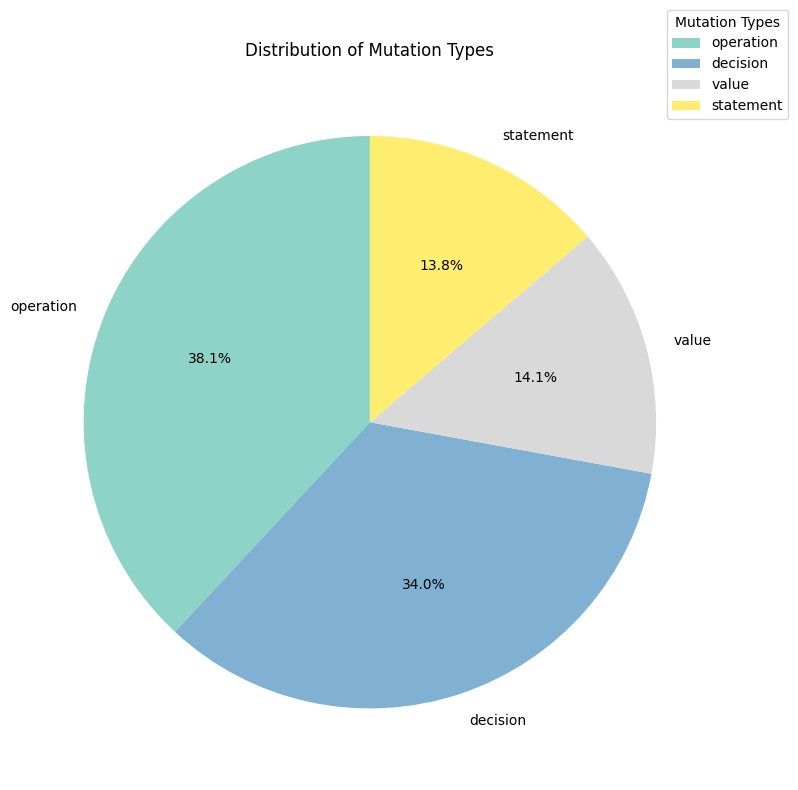

In [ ]:

import matplotlib.pyplot as plt

mutation_counts = df['mutation_type'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 8))
mutation_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap="Set3", legend=True)
plt.title('Distribution of Mutation Types')
plt.ylabel('')  # Remove y-axis label for better appearance

# Move the legend upwards
plt.legend(title='Mutation Types', bbox_to_anchor=(1, 1), loc='center', fontsize=10)

plt.tight_layout()
plt.show()